# Image Colorization Using Neural Network

## Introduction

  Image colorization is the process of assingning colors to a grayscale image to make it more aesthetically appealing and perceptually meaningful. These are recognized as sophisticated tasks than often require prior knowledge of image content and manual adjustments to achieve artefact-free quality.
Also, since objects can have different colors, there are many possible ways to assign colors to pixels in an image, which means there is no unique solution to this problem.

  Nowadays, image colorization is usually done by hand in Photoshop. Many institutions use image colorization services for assigning colors to grayscale historic images. There is also for colorization purposes in the documentation image. However, using Photoshop for this purpose requires more energy and time. One solution to this problem is to use machine learning / deep learning techniques. 

  Recently, deep learning has gained increasing attention among researchers in the field of computer vision and image processing. As a typical technique, convolutional neural network (CNNs) have been well-studied and successfully applied to several tasks such as image recognition, image reconstruction,  image  generation,  etc. (Nguyen et al., 2016)
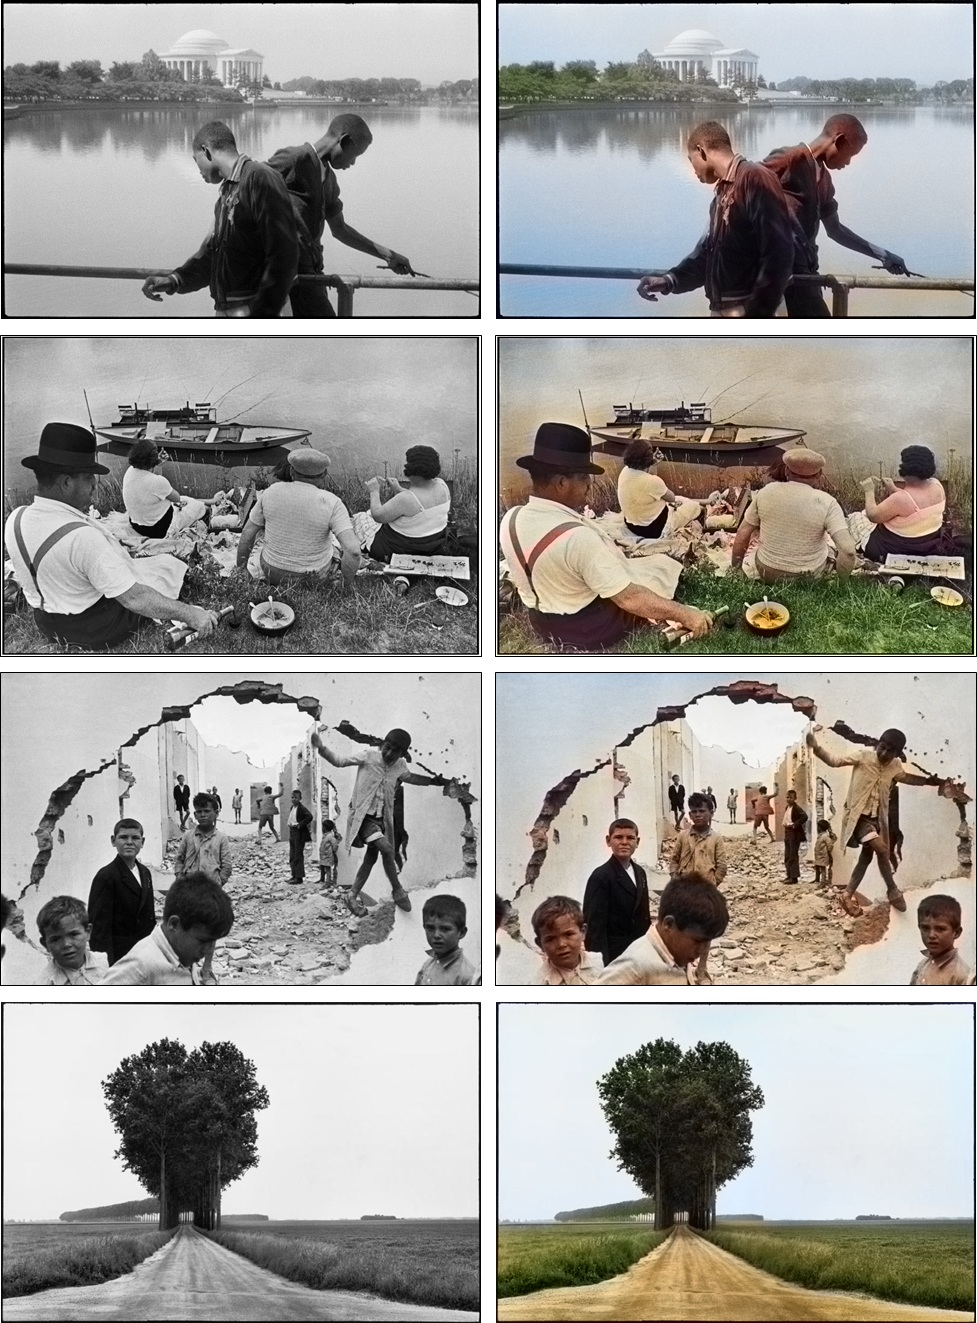

  A  CNN  consists  of multiple layers of small computational units that only process portions of the input  image  in a feed-forward fashion. Each layer is the  result  of  applying various image filters,  each  of which  extracts  a certain  feature  of  the  input  image,  to  the previous  layer.  Thus,  each  layer  may  contain  useful information  about  the  input  image  at  different  levels  of abstraction. 
  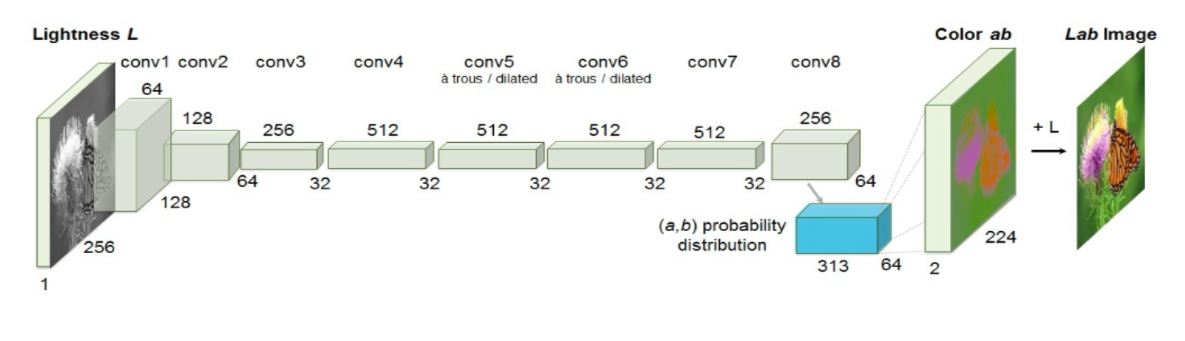

### Color Representation

So, how do we render an image, the basics of digital colors, and the main logic for our neural network. We can say that grayscale images can be represented in grids of pixels. 
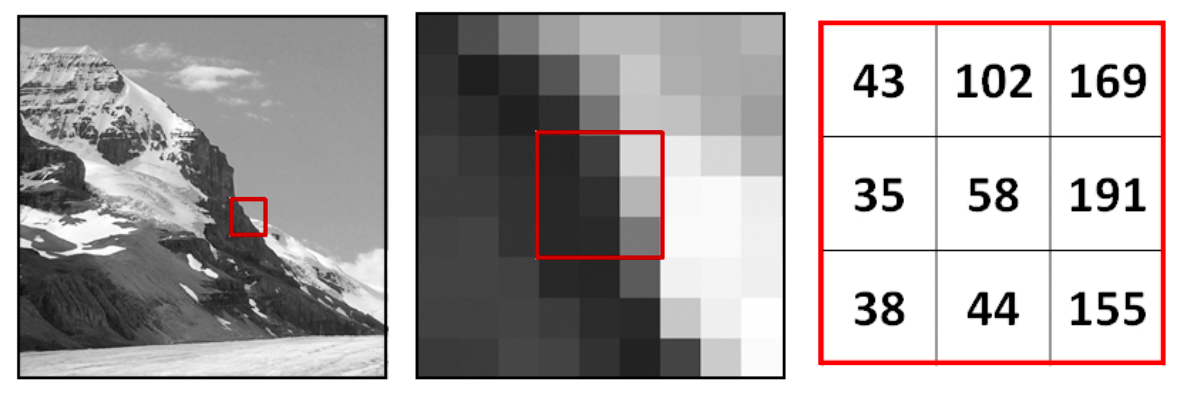

Source: https://gsp.humboldt.edu/OLM/Courses/GSP_216_Online/lesson3-1/raster-models.html




Each pixel has a value that corresponds to its brightness. The values span from 0–255, from black to white. While, a color image consist of three layers: Red, Green, Blue (RGB) layer. Let's imagine splitting a green leaf on a white background into three channels. As we know that the color of the leaf is only consist of the green layer. But, the leaf actually present in all three layers. The layes not only determine color, but also brightness.

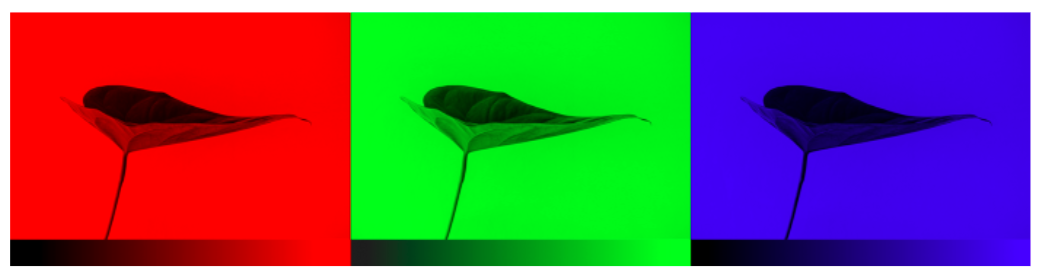

Source: https://emilwallner.medium.com/colorize-b-w-photos-with-a-100-line-neural-network-53d9b4449f8d

  Just like grayscale images, each layes in a color image has value from 0-255. The value 0 means that it has no color in that layer. If the value is 0 for all color channels, then the image pixel is black.
  A neural network creates a relatioship between an input value and output value. In this project the network needs to find the traits that link grayscale images with colored ones. So, we should search for the features that link a grid od grayscale values to the three color grids.

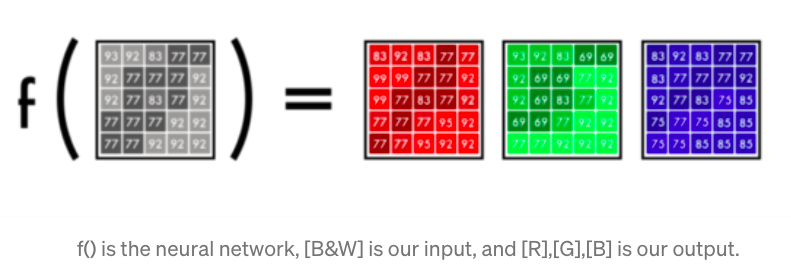

Source: https://emilwallner.medium.com/colorize-b-w-photos-with-a-100-line-neural-network-53d9b4449f8d

### Defining the Colorization Problem

Our final output is a colored image. We have a grayscale image for the input and we want to predict two color layers, the **ab** in **Lab**. To create the final color image we’ll include the **L**/grayscale image we used for the input. The result will be creating a **Lab** image. 

How we turn one layer into two layer? We use a convolutional filters. Let's say them as the red and blue filter in 3D glasses. They can hightlight or remove something to extract information out of the picture. The network can either create a new image from a filter or combine several filters into one image.


## Experiment

### Library and Setup

Before we get into detail how it works, lets import the necessary library:

*   `skimage` to convert RGB into lab format
*   `keras.layers` to made a layers for the model
*   `Sequential` for build the model
*   `ImageDataGenerator` to read / decode the image


In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

from skimage.color import rgb2lab, lab2rgb
from skimage.transform import resize
from skimage.io import imsave

import tensorflow as tf
from keras.layers import Conv2D, UpSampling2D
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img

### Data Preprocessing

**Normalize and Resize the Image**

Since the image we want to colour is a historic portrait image, the train data we use is also human image data that we can find in **Kaggle**. Our data train consist of **10.000+** images. 
Then we create image generators using `ImageDataGenerator` to read / decode the images and convert them into floating point tensors. Use the rescale argument to rescale / normilize the tensors from values between 0 and 255 to values between 0 and 1.


The methods of ImageDataGenerator class we using `flow_from_directory` method. This method is useful when the images are sorted and placed in there respective class/label folders. This method will identify classes automatically from the folder name.

In [2]:
train_dir = '/content/drive/MyDrive/algoritma/project1-colorization/train_img'
test_dir = '/content/drive/MyDrive/algoritma/project1-colorization/test_img'

#Resize images
img_width = 224
img_height = 224
image_size = (img_width, img_height)

**Create Augmented Images**

Since there are a small number of training examples there is a risk of overfitting. One way to fix this problem is by creating more training data from existing training examples by using random transformations.

We can add 4-6 random transformations as arguments to `ImageDataGenerator`. Make sure to rescale the same as before.

In [3]:
train_datagen = ImageDataGenerator(
        rotation_range=15,
        rescale=1./255,
        shear_range=0.1,
        zoom_range=0.2,
        horizontal_flip=True,
        featurewise_center=True)

In [4]:
train = train_datagen.flow_from_directory(batch_size=128,
                                                     directory=train_dir,
                                                     target_size=image_size,
                                                     class_mode=None)

Found 10964 images belonging to 1 classes.


**Convert the image from RGB to Lab**

This part is important because we working on color images anyway or we working on RGB image, meaning every image is very important and every channel is very important and we need to predict the value in every channel. So instead of doing that, for this project the easy way is by converting the RGB to Lab. 

Let’s first define the colorization problem in terms of the CIE Lab color space. Like the RGB color space, it is a 3-channel color space, but unlike the RGB color space, color information is encoded only in the a (green-red component) and b (blue-yellow component) channels. The L (lightness) channel encodes intensity information only.

By iterating on each image, we convert the RGB to Lab. Think of Lab image as a grey image in L channel and all color info stored in A and B channels. 
The input to the network will be the L channel, so we assign L channel to X vector. And assign A and B to Y.

To change the RGB into Lab image we using `rgb2lab()` function from `skimage` library.

After converting the color space using the function `rgb2lab()` we select the grayscale layer with: `[ : , : , 0]`. This is our input for the neural network. `[ : , : , 1: ]` selects the two color layers, green–red and blue–yellow.

The Lab color space has a different range in comparison to RGB. The color spectrum ab in Lab ranges from -128 to 128. By dividing all values in the output layer by 128, we bound the range between -1 and 1.

In [5]:
#Convert from RGB to LAB
X = []
y = []
for img in train[0]:
  try:
    lab = rgb2lab(img)
    X.append(lab[:,:,0])
    y.append(lab[:,:,1:] / 128)
  except:
    print('error')
X = np.array(X)
y = np.array(y)

X = X.reshape(X.shape+(1,)) #dimensions to be the same for X and Y
print(X.shape)
print(y.shape)

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


(128, 224, 224, 1)
(128, 224, 224, 2)


In [ ]:
# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [ ]:
print(X_train.shape)

(102, 224, 224, 1)


In [ ]:
print(y_train.shape)

(102, 224, 224, 2)


In [ ]:
print(X_test.shape)

(26, 224, 224, 1)


### Model Architecture

**CNN Architecture for Colorization**

The architecture proposed by [Zhang et a](https://richzhang.github.io/)l is a VGG-style network with multiple convolutional blocks. Each block has two or three convolutional layers followed by a Rectified Linear Unit (ReLU) and terminating in a Batch Normalization layer. Unlike the VGG net, there are no pooling or fully connected layers.

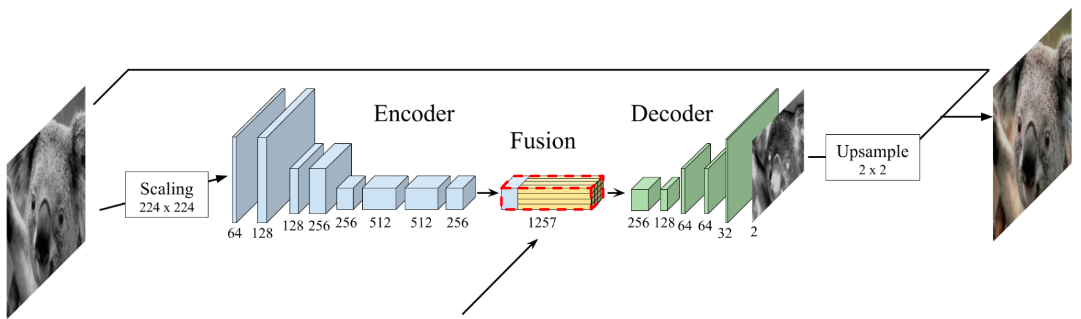

Image above is about CNN architecture for colorization. 

**Encoder**
As we can see from the image above, the input image is rescaled to 224x224. The input represented by `H x W x 1` (L component) a grayscale images. While the output `H/8 x W/8 x 512` feature reperestation. It uses 8 Convolutional layers with 3x3 kernels that alternate stride 1 and padding to preserve teh input size, stride 2 to halve the input size. The encoder network, each convolutional layer uses a `ReLu` activation function.

**Decoder**
To create convolutional layers to up-sampling. The final output H x W x 2 (a*b* component) that applies a series of convolutional layers. For the last layer we use tanh instead of Relu. This is because we are colorizing the image in this layer using 2 filters, A and B. A and B values range between -1 and 1 so tanh (or hyperbolic tangent) is used as it also has the range between -1 and 1. Other functions go from 0 to 1.


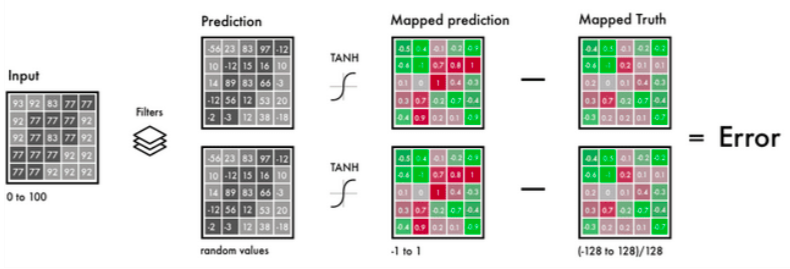

From the left side we have the grayscale input, our filters, and the prediction from our neural network.
We map the predicted values and the real values within the same interval. This way, we can compare the values. The interval ranges from -1 to 1. To map the predicted values, we use a tanh activation function. For any value you give the tanh function, it will return -1 to 1.
The true color values range between -128 and 128. This is the default interval in the Lab color space. By dividing them by 128, they too fall within the -1 to 1 interval. This “normalization” enables us to compare the error from our prediction.
After calculating the final error, the network updates the filters to reduce the total error. The network continues in this loop until the error is as low as possible.

In [6]:
#Built model

#Encoder
model = Sequential()
model.add(Conv2D(64, (3, 3), activation='relu', padding='same', strides=2, input_shape=(224, 224, 1)))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(128, (3,3), activation='relu', padding='same', strides=2))
model.add(Conv2D(256, (3,3), activation='relu', padding='same'))
model.add(Conv2D(256, (3,3), activation='relu', padding='same', strides=2))
model.add(Conv2D(512, (3,3), activation='relu', padding='same'))
model.add(Conv2D(512, (3,3), activation='relu', padding='same'))
model.add(Conv2D(256, (3,3), activation='relu', padding='same'))

#Decoder
model.add(Conv2D(128, (3,3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(64, (3,3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(32, (3,3), activation='relu', padding='same'))
model.add(Conv2D(16, (3,3), activation='relu', padding='same'))
model.add(Conv2D(2, (3, 3), activation='tanh', padding='same'))
model.add(UpSampling2D((2, 2)))
model.compile(optimizer='adam', loss='mse' , metrics=['accuracy'])
model.summary()

history = model.fit(x=X,y=y,validation_split=0.2, epochs=800, batch_size=128)

# history = model.fit(x=X_train,validation_data=X_test, epochs=25)

# (x = training_set, validation_data = test_set, epochs = 25)



Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 112, 112, 64)      640       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 128)       147584    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 56, 56, 256)       295168    
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 28, 28, 256)       590080    
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 28, 28, 512)       1180160   
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 28, 28, 512)       2



---



### Model Fitting

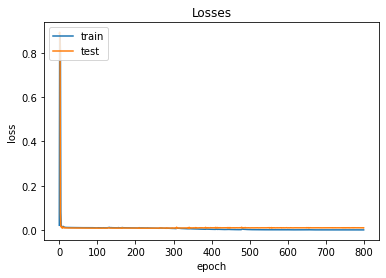

In [7]:
plt.plot(history.history['loss'], '-')
plt.plot(history.history['val_loss'], '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'test'], loc='upper left')
plt.title('Losses');

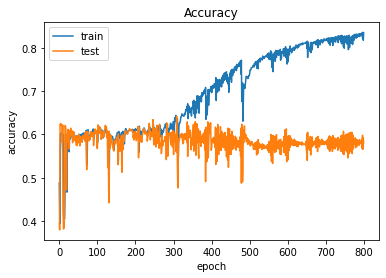

In [8]:
plt.plot(history.history['accuracy'], '-')
plt.plot(history.history['val_accuracy'], '-')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train', 'test'], loc='upper left')
plt.title('Accuracy');

**After training the model, we can save using `save()` function.**

In [9]:
#save model
model.save('/content/drive/MyDrive/algoritma/project1-colorization/colorization1000.model')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/algoritma/project1-colorization/colorization1000.model/assets


## Result and Discussion

After we train and save the model, finally we can use to colorize the grayscale image by load the saved model using `load_model()` function.

In [20]:
# Load saved model
models = tf.keras.models.load_model(
    '/content/drive/MyDrive/algoritma/project1-colorization/colorization1000.model',
    custom_objects=None,
    compile=True)

Open the data test and preprocess the image

In [73]:
# Load and preprocessing the test images
test_dir = '/content/drive/MyDrive/algoritma/project1-colorization/test_img/test_images'

#Resize images
img_width = 224
img_height = 224
image_size = (img_width, img_height)

test_datagen = ImageDataGenerator(
        rescale=1./255,
        )

test = test_datagen.flow_from_directory(batch_size=128,
                                                     directory=test_dir,
                                                     target_size=image_size,
                                                     class_mode=None)

Found 1 images belonging to 1 classes.


Convert into LAB

In [53]:
#Convert to LAB
test_img = []
for img in test[0]:
  try:
    lab = rgb2lab(img)
    test_img.append(lab[:,:,0])
  except:
    print('error')
test_img = np.array(test_img)

test_img = test_img.reshape(test_img.shape+(1,)) #dimensions to be the same for test_img
print(test_img.shape)

(1, 224, 224, 1)


In [69]:
grayscale = np.zeros((224, 224, 3))
grayscale[:,:,0] = test_img[0][:,:,0]
grayscale = resize(grayscale, (800,600))
gray_img = lab2rgb(grayscale)
#imsave("/content/drive/MyDrive/algoritma/project1-colorization/grayscale_img/gray_result1.jpg", rgb2lab(grayscale))

In [55]:
output1 = models.predict(test_img)
output1 = output1*128

In [56]:
result = np.zeros((224, 224, 3))
result[:,:,0] = test_img[0][:,:,0]
result[:,:,1:] = output1[0]
result = resize(result, (800,600))
color_img = lab2rgb(result)
#imsave("/content/drive/MyDrive/algoritma/project1-colorization/result_img/result1.jpg", lab2rgb(result))

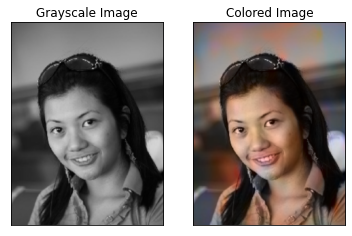

In [76]:
titles = ['Grayscale Image', 'Colored Image']
images = [gray_img, color_img]
for i in range(2):
  plt.subplot(1, 2, i+1)
  plt.imshow(images[i])
  plt.title(titles[i])
  plt.xticks([])
  plt.yticks([])
plt.show()

Once trained, we fed out network with some images. The result turned out to be quite good for some of the images. For instance, natural element such as skin color and hair color to be well recognized. However, specific object are not colored. Figure above illustrates results for some examples where out network produces alternative colored estimates.

## Conclusion and Future Work

This project validates that an end-to-end deep learning architecture could be suitable for some image colorization tasks.

Overall, we believe that while image colorization might require some degree of human intervention it still a huge potential in the future and could eventually reduce hours of supervised work.

## References



*   [Nguyen. Tung, Mori. Kazuki, Thowanmas. Ruck, 2016; Image Colorization Using a Deep Convolutional Neural Network.](https://www.researchgate.net/publication/301817406_Image_Colorization_Using_a_Deep_Convolutional_Neural_Network)
*   [AISegment.com - Matting Human Datasets, Kaggle ](https://www.kaggle.com/laurentmih/aisegmentcom-matting-human-datasets)
* https://richzhang.github.io/
* https://github.com/baldassarreFe/deep-koalarization

